In [ ]:
# Khai báo các thư viện sử dụng

import numpy as np # xử lý dữ liệu
import pandas as pd # đọc dữ liệu
import matplotlib.pyplot as plt # vẽ biểu đồ
import seaborn as sns
import datetime as dt # định dạng date
from datetime import datetime # định dạng date
%matplotlib inline
plt.style.use('ggplot')

# Khởi tạo các lớp cho mô hinh LSTM
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

# Chuẩn hóa dữ liệu
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Cho phép truy cập vào Google Drive
from google.colab import drive
drive.mount("/drive")

Mounted at /drive


In [ ]:
df = pd.read_csv("/drive/MyDrive/KLTN_StockPriceLSTM/StockPrice_VNINDEX.csv")
df.head() # in ra 5 dòng đầu tiên

,Ngày,Lần cuối,Mở,Cao,Thấp,KL,% Thay đổi
0,23/10/2023,"1,089.80","1,108.03","1,108.03","1,089.21",265.06K,-1.65%
1,20/10/2023,"1,108.03","1,087.85","1,108.16","1,073.73",658.19K,1.86%
2,19/10/2023,"1,087.85","1,103.40","1,104.03","1,087.85",649.23K,-1.41%
3,18/10/2023,"1,103.40","1,121.65","1,125.27","1,088.87",1.04M,-1.63%
4,17/10/2023,"1,121.65","1,145.34","1,147.89","1,121.65",610.50K,-1.73%


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3444 entries, 0 to 3443
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Ngày        3444 non-null   object
 1   Lần cuối    3444 non-null   object
 2   Mở          3444 non-null   object
 3   Cao         3444 non-null   object
 4   Thấp        3444 non-null   object
 5   KL          3444 non-null   object
 6   % Thay đổi  3444 non-null   object
dtypes: object(7)
memory usage: 188.5+ KB


In [ ]:
cols = list(df)[1:7] # lấy ra các cột (feature) dùng để dự đoán
datelist_train = list(df['Ngày']) # lấy ra danh sách cột Date
datelist_train = [dt.datetime.strptime(date, '%d/%m/%Y').date() for date in datelist_train] # định dạng cột cột Date thành datetime64[ns]

print('Training set shape : {}'.format(df.shape)) # in ra hình dạng
print('All timestamps : {}'.format(len(datelist_train))) # in ra độ dài
print('Feature selecte : {}'.format(cols)) # in ra các cột (feature) được chọn dự đoán

Training set shape : (3444, 7)
All timestamps : 3444
Feature selecte : ['Lần cuối', 'Mở', 'Cao', 'Thấp', 'KL', '% Thay đổi']


In [ ]:
# danh sách cột Date để dùng làm chỉ mục (index) cho tập dữ liệu
df.index = datelist_train
df.index = pd.to_datetime(df.index)
df = df.sort_index(ascending = True)
df

,Ngày,Lần cuối,Mở,Cao,Thấp,KL,% Thay đổi
2010-01-04,04/01/2010,517.05,501.74,517.05,501.74,44.92K,4.50%
2010-01-05,05/01/2010,532.53,529.23,539.39,529.23,70.05K,2.99%
2010-01-06,06/01/2010,534.46,529.47,538.84,526.37,67.36K,0.36%
2010-01-07,07/01/2010,533.34,536.78,540.77,530.68,75.68K,-0.21%
2010-01-08,08/01/2010,520.90,540.95,544.49,520.90,84.72K,-2.33%
...,...,...,...,...,...,...,...
2023-10-17,17/10/2023,"1,121.65","1,145.34","1,147.89","1,121.65",610.50K,-1.73%
2023-10-18,18/10/2023,"1,103.40","1,121.65","1,125.27","1,088.87",1.04M,-1.63%
2023-10-19,19/10/2023,"1,087.85","1,103.40","1,104.03","1,087.85",649.23K,-1.41%
2023-10-20,20/10/2023,"1,108.03","1,087.85","1,108.16","1,073.73",658.19K,1.86%


In [ ]:
datelist_train = list(df.index)

In [ ]:
datelist_train[:10]

[Timestamp('2010-01-04 00:00:00'),
 Timestamp('2010-01-05 00:00:00'),
 Timestamp('2010-01-06 00:00:00'),
 Timestamp('2010-01-07 00:00:00'),
 Timestamp('2010-01-08 00:00:00'),
 Timestamp('2010-01-11 00:00:00'),
 Timestamp('2010-01-12 00:00:00'),
 Timestamp('2010-01-13 00:00:00'),
 Timestamp('2010-01-14 00:00:00'),
 Timestamp('2010-01-15 00:00:00')]

In [ ]:
df_feature = pd.DataFrame(df, columns=cols) # Lấy các feature được chọn vào dataset
df_feature

,Lần cuối,Mở,Cao,Thấp,KL,% Thay đổi
2010-01-04,517.05,501.74,517.05,501.74,44.92K,4.50%
2010-01-05,532.53,529.23,539.39,529.23,70.05K,2.99%
2010-01-06,534.46,529.47,538.84,526.37,67.36K,0.36%
2010-01-07,533.34,536.78,540.77,530.68,75.68K,-0.21%
2010-01-08,520.90,540.95,544.49,520.90,84.72K,-2.33%
...,...,...,...,...,...,...
2023-10-17,"1,121.65","1,145.34","1,147.89","1,121.65",610.50K,-1.73%
2023-10-18,"1,103.40","1,121.65","1,125.27","1,088.87",1.04M,-1.63%
2023-10-19,"1,087.85","1,103.40","1,104.03","1,087.85",649.23K,-1.41%
2023-10-20,"1,108.03","1,087.85","1,108.16","1,073.73",658.19K,1.86%


In [ ]:
# Kiểm tra kiểu dữ liệu và xem xét xem có cần chuyển đổi kiểu dữ liệu hay không
df_feature['Lần cuối'] = df_feature['Lần cuối'].str.replace(',', '').astype(float)
df_feature['Mở'] = df_feature['Mở'].str.replace(',', '').astype(float)
df_feature['Cao'] = df_feature['Cao'].str.replace(',', '').astype(float)
df_feature['Thấp'] = df_feature['Thấp'].str.replace(',', '').astype(float)
df_feature['% Thay đổi'] = df_feature['% Thay đổi'].str.rstrip('%').astype(float) / 100

In [ ]:
def convert_KL(volume_str):
  if 'K' in volume_str:
    return float(volume_str.replace('K','').replace(',','')) * 1000
  if 'M' in volume_str:
    return float(volume_str.replace('M','').replace(',','')) * 1000000
  else:
    return float(volume_str.replace(',',''))


df_feature['KL'] = df_feature['KL'].apply(convert_KL)

In [ ]:
df_feature.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3444 entries, 2010-01-04 to 2023-10-23
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Lần cuối    3444 non-null   float64
 1   Mở          3444 non-null   float64
 2   Cao         3444 non-null   float64
 3   Thấp        3444 non-null   float64
 4   KL          3444 non-null   float64
 5   % Thay đổi  3444 non-null   float64
dtypes: float64(6)
memory usage: 188.3 KB


In [ ]:
df_feature.describe()

,Lần cuối,Mở,Cao,Thấp,KL,% Thay đổi
count,3444.000000,3444.000000,3444.000000,3444.000000,3.444000e+03,3444.000000
mean,776.722509,776.763612,781.881664,771.235511,4.114159e+05,0.000300
std,307.050330,307.084596,309.193529,304.404611,4.030139e+06,0.011842
min,336.730000,334.930000,339.320000,332.280000,1.493000e+04,-0.066700
25%,505.662500,505.407500,507.740000,503.320000,7.218750e+04,-0.005100
50%,676.320000,675.750000,679.760000,672.790000,1.490500e+05,0.001000
75%,995.277500,995.750000,999.885000,989.675000,3.067875e+05,0.006900
max,1528.570000,1534.100000,1536.450000,1524.960000,1.212500e+08,0.049800


In [ ]:
df_feature.head()

,Lần cuối,Mở,Cao,Thấp,KL,% Thay đổi
2010-01-04,517.05,501.74,517.05,501.74,44920.0,0.0450
2010-01-05,532.53,529.23,539.39,529.23,70050.0,0.0299
2010-01-06,534.46,529.47,538.84,526.37,67360.0,0.0036
2010-01-07,533.34,536.78,540.77,530.68,75680.0,-0.0021
2010-01-08,520.90,540.95,544.49,520.90,84720.0,-0.0233


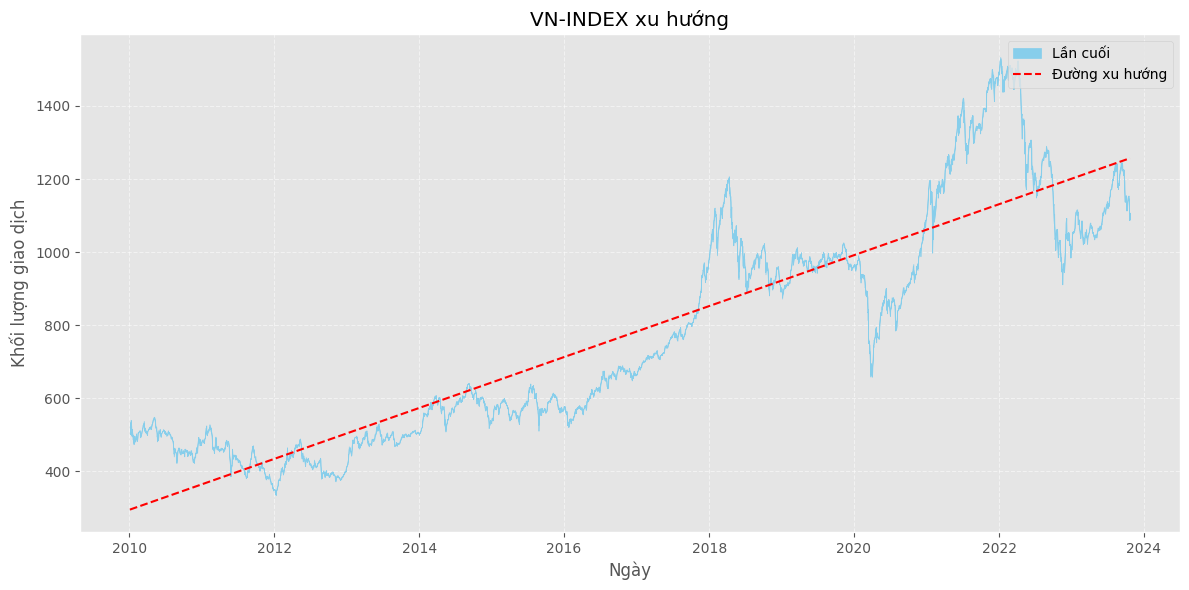

In [ ]:
plt.figure(figsize = (12,6))

# Chuyển đổi kiểu dữ liệu của cột "Lần cuối"
df_feature["Lần cuối"] = pd.to_numeric(df_feature["Lần cuối"])

# Tạo biểu đồ vùng cho khối lượng giao dịch của chỉ số
plt.fill_between(df_feature.index, df_feature["Mở"], df_feature["Lần cuối"], label="Lần cuối", color="skyblue")

# Thêm đường xu hướng
z = np.polyfit(df_feature.index.astype(np.int64) // 10**9, df_feature["Lần cuối"], 1)
p = np.poly1d(z)
plt.plot(df_feature.index, p(df_feature.index.astype(np.int64) // 10**9), color="red", linestyle="--", label="Đường xu hướng")

# Thêm chú thích vào biểu đồ
plt.title("VN-INDEX xu hướng")
plt.xlabel("Ngày")
plt.ylabel("Khối lượng giao dịch")
plt.legend()

# Tùy chỉnh các trục và lưới
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()


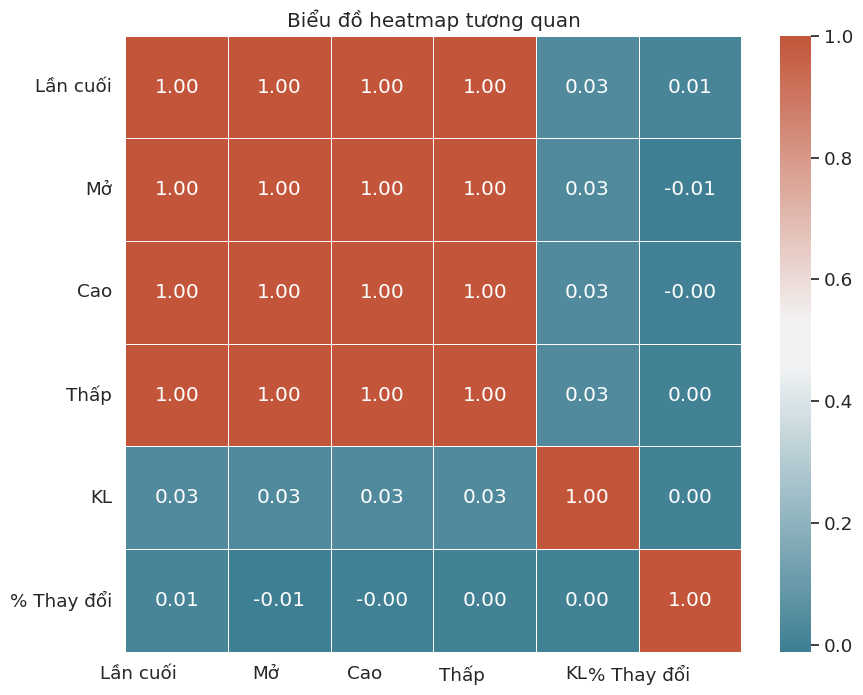

In [ ]:
# Tạo biểu đồ heatmap với các tùy chỉnh
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)  # Tùy chỉnh kích thước font chữ
sns.set_style("whitegrid")  # Tùy chỉnh nền và lưới cho biểu đồ
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)  # Tùy chỉnh màu sắc
ax = sns.heatmap(df_feature.corr(), annot=True, cmap=cmap, fmt=".2f", square=True, linewidths=0.5)
plt.title("Biểu đồ heatmap tương quan")

# Tùy chỉnh màu cột và hàng
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right')

plt.show()

In [ ]:
training_set = df_feature.values # lấy ra các giá trị trong bộ dữ liệu mỗi cột

print('Shape of training set = {}.'.format(training_set.shape)) # in ra hình dạng train set
training_set

Shape of training set = (3444, 6).


array([[ 5.17050e+02,  5.01740e+02,  5.17050e+02,  5.01740e+02,
         4.49200e+04,  4.50000e-02],
       [ 5.32530e+02,  5.29230e+02,  5.39390e+02,  5.29230e+02,
         7.00500e+04,  2.99000e-02],
       [ 5.34460e+02,  5.29470e+02,  5.38840e+02,  5.26370e+02,
         6.73600e+04,  3.60000e-03],
       ...,
       [ 1.08785e+03,  1.10340e+03,  1.10403e+03,  1.08785e+03,
         6.49230e+05, -1.41000e-02],
       [ 1.10803e+03,  1.08785e+03,  1.10816e+03,  1.07373e+03,
         6.58190e+05,  1.86000e-02],
       [ 1.08980e+03,  1.10803e+03,  1.10803e+03,  1.08921e+03,
         2.65060e+05, -1.65000e-02]])

In [ ]:
# Chuẩn hóa dữ liệu train set trước khi điều chỉnh mô hình bằng MinMaxScaler()
# Mở rộng tính năng (Feature Scaling)
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(training_set)

# Chuẩn hóa dữ liệu target (cột 'Lần cuối') dự đoán
sc_predict = MinMaxScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[0.15129548],
       [0.1642838 ],
       [0.16590314],
       ...,
       [0.63021882],
       [0.64715062],
       [0.63185495]])

In [ ]:
#Theo yêu cầu đối với mạng LSTM, bắt buộc phải định hình lại dữ liệu đầu vào thành n_samples x dấu thời gian x n_features.
# Trong ví dụ này, n_features là 6. Chúng tôi sẽ đặt dấu thời gian = 7 (dữ liệu ngày qua được sử dụng để đào tạo).
X_train = []
y_train = []

n_future = 1  # Số ngày muốn dự đoán trong tương lai
n_past = 1   # Số ngày trong quá khứ dùng để dự đoán tương lai

# Tạo cấu trúc dữ liệu với 60 dấu thời gian và 1 đầu ra
for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:df_feature.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train) # chuyển X_train y_train thành một array

print('X_train shape = {}.'.format(X_train.shape)) # in ra hình dạng X_train
print('y_train shape = {}.'.format(y_train.shape)) # in ra hình dạng y_train

X_train shape = (3443, 1, 5).
y_train shape = (3443, 1).


In [ ]:
# Khởi tạo Mạng Neural dựa trên mô hình LSTM
model = Sequential()

# Thêm lớp LSTM thứ nhất gồm 64 nút và đầu vào là (dấu thời gian x n_features)
model.add(LSTM(units=64,return_sequences=True,activation= 'tanh' ,input_shape=(n_past, df_feature.shape[1] - 1)))

#Thêm lớp LTSM thứ hai gồm 32 nút
model.add(LSTM(units=32,activation= 'tanh', return_sequences=True))

# Thêm dropout xóa ngẫu nhiên 20% các dữ liệu để tránh học tủ
model.add(Dropout(0.2))

#Thêm lớp LTSM thứ hai gồm 32 nút
model.add(LSTM(units=16,activation= 'tanh', return_sequences=False))

# Thêm dropout xóa ngẫu nhiên 20% các dữ liệu để tránh học tủ
model.add(Dropout(0.2))

# Thêm một lớp Densen với đầu ra là 1, hàm kích hoạt linear
model.add(Dense(units=1))

# Biên dịch mô hình với hàm tối ưu là Adam và loss function là MSE
model.compile(optimizer = 'adam', loss='mean_squared_error')

# cho ra thông tin mô hình
model.summary()

In [ ]:
# Huấn luyện mô hình với epochs = 5, batch_size = 32
history = model.fit(X_train, y_train,epochs=5, validation_split=0.1, verbose=1, batch_size=32)

Epoch 1/5
97/97 [==============================] - 7s 18ms/step - loss: 0.0629 - val_loss: 0.0010
Epoch 2/5
97/97 [==============================] - 1s 8ms/step - loss: 0.0059 - val_loss: 4.2337e-04
Epoch 3/5
97/97 [==============================] - 1s 8ms/step - loss: 0.0049 - val_loss: 3.3124e-04
Epoch 4/5
97/97 [==============================] - 1s 8ms/step - loss: 0.0041 - val_loss: 2.6872e-04
Epoch 5/5
97/97 [==============================] - 1s 8ms/step - loss: 0.0035 - val_loss: 3.7925e-04


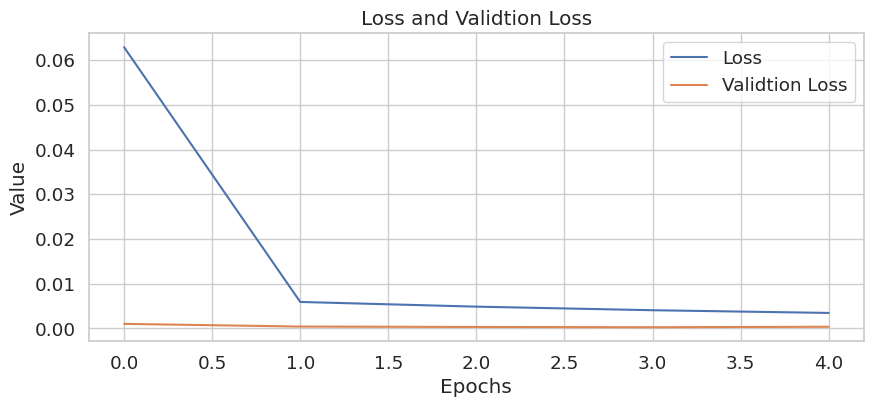

In [ ]:
# Vẽ biểu đồ sự thay đổi của Loss và Val_loss qua mỗi lần huấn luyện
plt.figure(figsize = (10,4))
plt.plot(history.history['loss'], label = 'Loss')
plt.plot(history.history['val_loss'], label = 'Validtion Loss')
plt.title('Loss and Validtion Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show();

In [ ]:
# tạo ra danh sách một chuỗi các ngày dự đoán tiếp theo bằng hàm date_range
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()
datelist_futures = []

# chuyển đổi danh sách ngày các ngày trong tương lai thành dạng object Datetime --> để dự đoán trong tương lai
for time_future in datelist_future:
    datelist_futures.append(time_future.date())

In [ ]:
pred_future = model.predict(X_train[-n_future:]) # Thực hiện dự đoán các ngày tương lai
pred_train = model.predict(X_train[n_past:]) # Thực hiện dự đoán các ngày trong khoảng thời gian

108/108 [==============================] - 0s 4ms/step


In [ ]:
# Hàm chức năng đảo ngược lại từ datelist_futures
def datetime_to_timestamp(x):
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')

y_pred_future = sc_predict.inverse_transform(pred_future) # đảo ngược lại giá trị ban đầu sau khi chuẩn hóa của giá trong tương lai
y_pred_train = sc_predict.inverse_transform(pred_train) # đảo ngược lại giá trị ban đầu sau khi chuẩn hóa giá trị

# Tạo Dataframe để hiển thị ra các giá lần cuối thực tế (Actual) và giá mở cửa dự đoán (Predict)
df_pred_future = pd.DataFrame(y_pred_future, columns=['Lần cuối tương lai']).set_index(pd.Series(datelist_future))
df_pred_train = pd.DataFrame(y_pred_train, columns=['Lần cuối dự đoán']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Chuyển đổi tất cả ngày trong chỉ mục trong df_pred_train bằng phương thức apply() với đầu vào là hàm datetime_to_time
df_pred_train.index = df_pred_train.index.to_series().apply(datetime_to_timestamp)

# In ra DataFrame so sánh giá lần dự đoán và giá lần cuối thực tế
df_pred_train['Lần cuối thực tế'] = df_feature["Lần cuối"]
df_pred_train.head(10)

,Lần cuối dự đoán,Lần cuối thực tế
2010-01-06,533.191040,534.46
2010-01-07,532.866943,533.34
2010-01-08,535.817261,520.90
2010-01-11,532.938782,515.06
2010-01-12,521.035889,498.31
2010-01-13,510.389465,508.61
2010-01-14,504.246002,512.33
2010-01-15,516.985962,505.42
2010-01-18,511.513702,487.13
2010-01-19,499.250183,495.51


In [ ]:
df_pred_future# In ra giá mở cửa trong ngày tương lai

,Lần cuối tương lai
2023-10-23,1109.695557


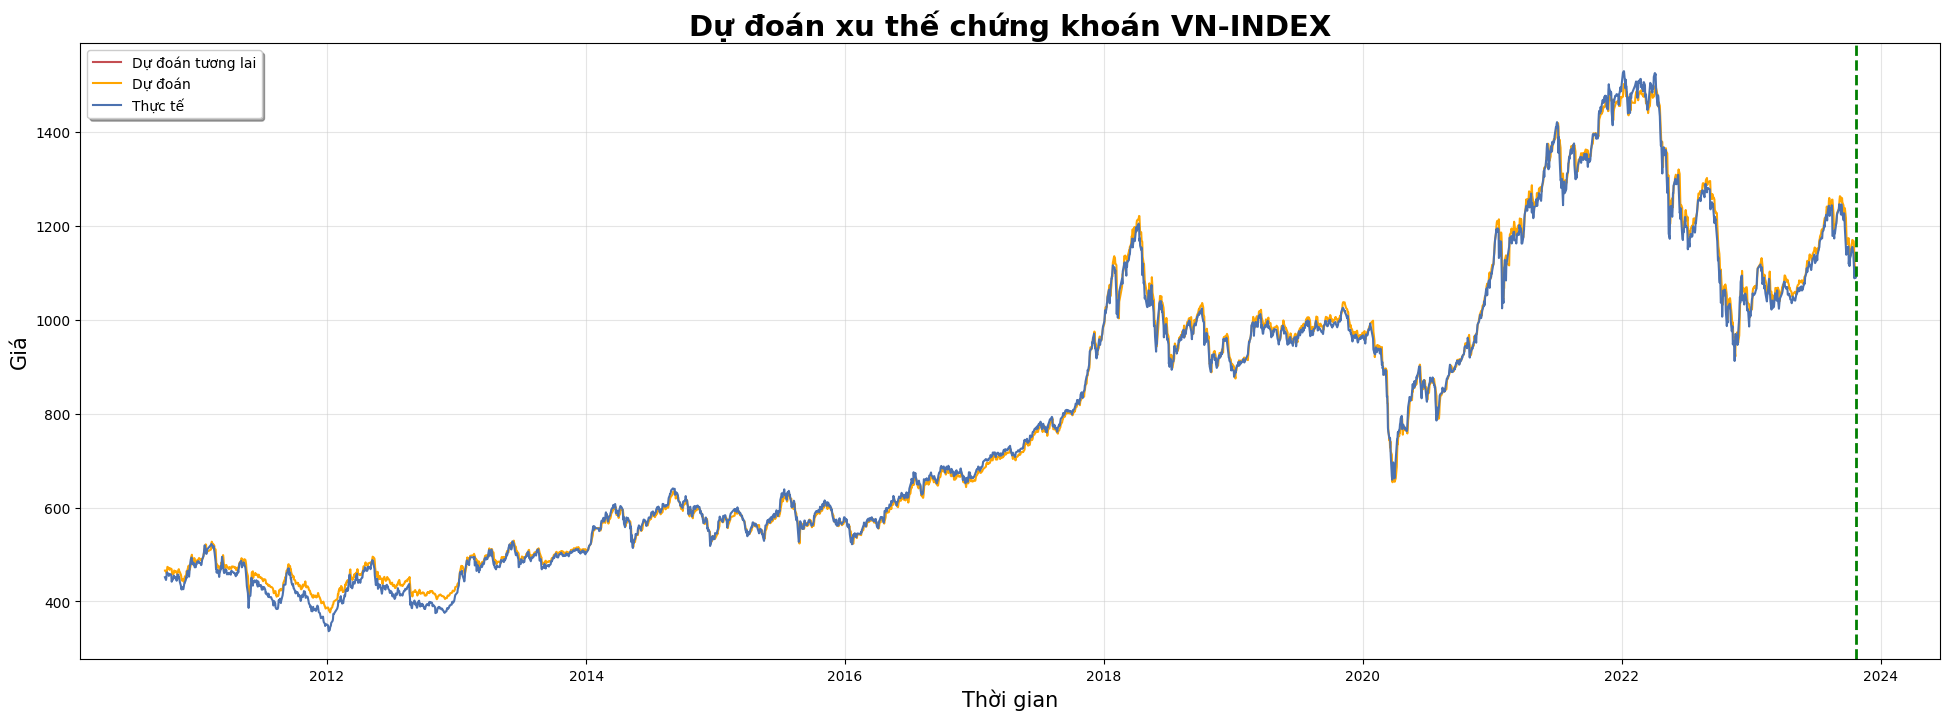

In [ ]:
# Vẽ biểu đồ thể hiện giá Lần cuói sau khi sử dụng mô hình LSTM để dự đoán
plt.figure(figsize = (24,8))
plt.style.use('default')

start_date_for_plot = '2010-10-01' # Ngày bắt đầu để vẽ

#Vẽ biểu đồ line giá Lần cuói dự đoán ngày tương lai
plt.plot(df_pred_future.index, df_pred_future['Lần cuối tương lai'], color='r', label='Dự đoán tương lai')

#Vẽ biểu đồ line giá Lần cuói dự đoán trong tập dữ liệu
plt.plot(df_pred_train.loc[start_date_for_plot:].index, df_pred_train.loc[start_date_for_plot:]['Lần cuối dự đoán'], color='orange', label='Dự đoán')

# Vẽ biểu đồ line giá Lần cuói thực tế của tập dữ liệu
plt.plot(df_feature.loc[start_date_for_plot:].index, df_feature.loc[start_date_for_plot:]["Lần cuối"], color='b', label='Thực tế')

# Vẽ đường phân cách bắt đầu ngày dự đoán trong tương lai
plt.axvline(x = min(df_pred_future.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Dự đoán xu thế chứng khoán VN-INDEX', fontsize=21, weight = 'bold')
plt.xlabel('Thời gian', fontsize=15)
plt.ylabel('Giá', fontsize=15)
plt.show()